## Imports

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve, plot_roc_curve, plot_confusion_matrix, classification_report
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

## Basic exploration

In [39]:
df = pd.read_csv('../Data/Churn_Modelling.csv')

In [40]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [41]:
df.shape

(10000, 14)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [43]:
# Dropping unwanted columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [44]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [8]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no null values in the data

In [9]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The features Tenure, NumOfProducts, HasCrCard, and IsActiveMember should be converted to catergorical features

## EDA

<AxesSubplot:xlabel='Exited', ylabel='count'>

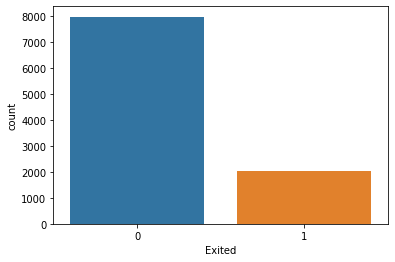

In [10]:
sns.countplot(data=df, x='Exited')

The data is heavily unbalanced. We need to balance the data before predictions

In [45]:
# Splitting the features into continuous and categorical for exploration purposes
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

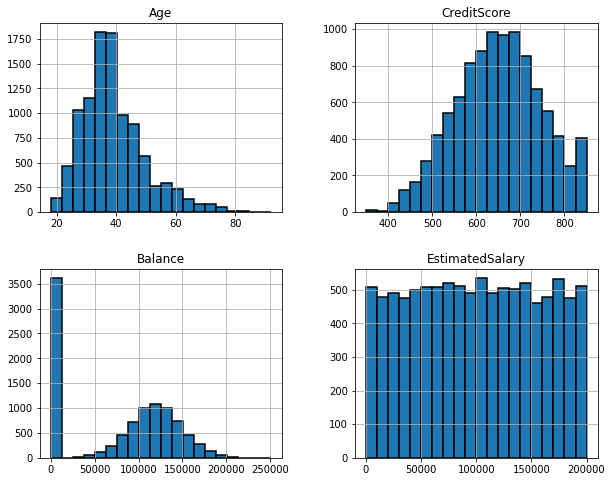

In [12]:
df[continuous].hist(figsize=(10,8), bins=20, edgecolor='black', linewidth=1.5);

- The age feature is right skewed
- Most of the credit scores are above 600
- The estimated salary feature is distributed uniformly
- The balance feature is normally distributed if we remove the first bin

<AxesSubplot:>

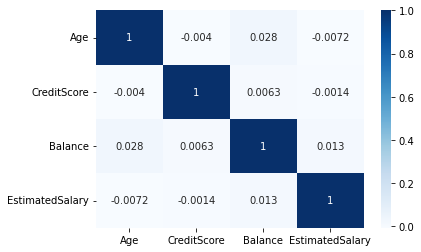

In [13]:
sns.heatmap(df[continuous].corr(), annot=True, cmap='Blues')

There is no mulitcollinearity between the continuous features

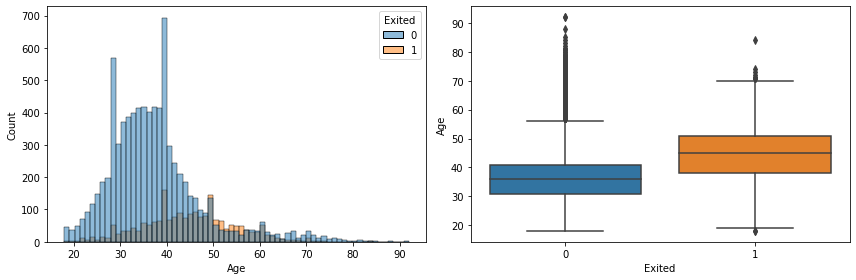

In [14]:
figure, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(ax=axes[0], data=df, x='Age', hue='Exited')
sns.boxplot(ax=axes[1], data=df, x='Exited', y='Age')
plt.tight_layout();

Old customers are more likely to churn than the new customers

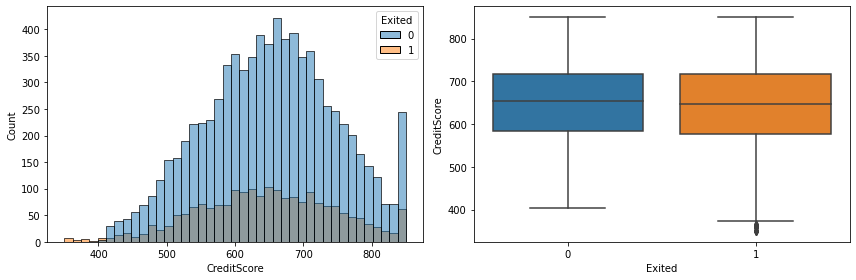

In [15]:
figure, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(ax=axes[0], data=df, x='CreditScore', hue='Exited')
sns.boxplot(ax=axes[1], data=df, x='Exited', y='CreditScore')
plt.tight_layout();

No significant differences observed in the CreditScore feature

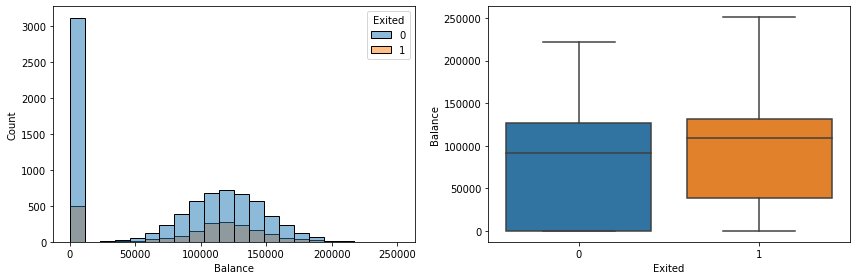

In [16]:
figure, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(ax=axes[0], data=df, x='Balance', hue='Exited')
sns.boxplot(ax=axes[1], data=df, x='Exited', y='Balance')
plt.tight_layout();

Not much significant differences were observed but the customers with less balance are not likely to churn

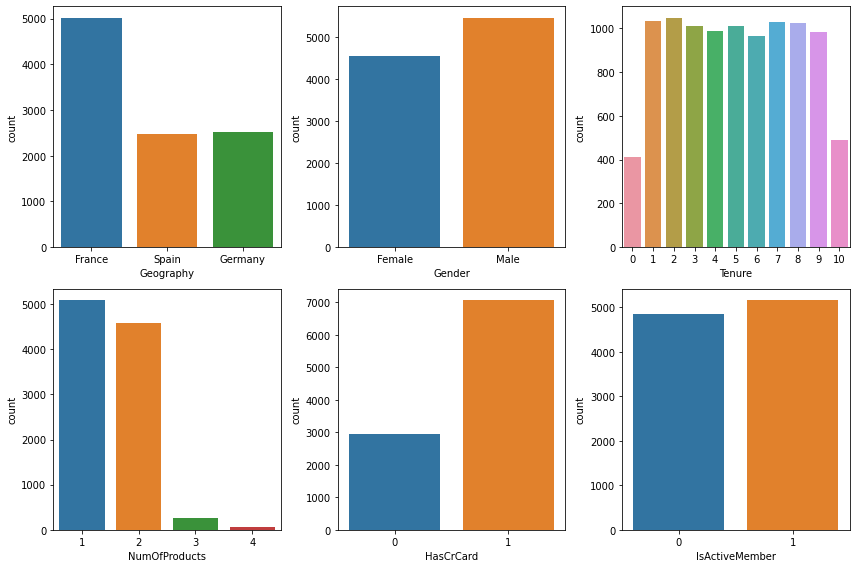

In [17]:
plt.figure(figsize=(12, 8))
for i, j in enumerate(df[categorical].columns):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=df[categorical], x=j)
plt.tight_layout();

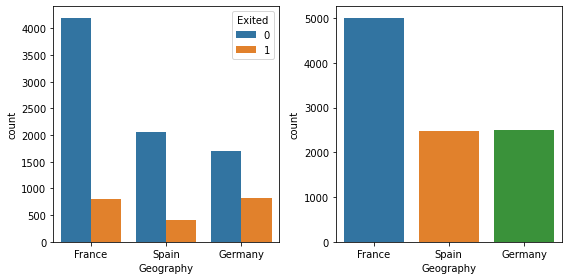

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(ax=axes[0], data=df, x='Geography', hue='Exited')
sns.countplot(ax=axes[1], data=df, x='Geography')
plt.tight_layout();

- Customers in Germany are more likely to churn
- France has the lowest churn relative to the total customers

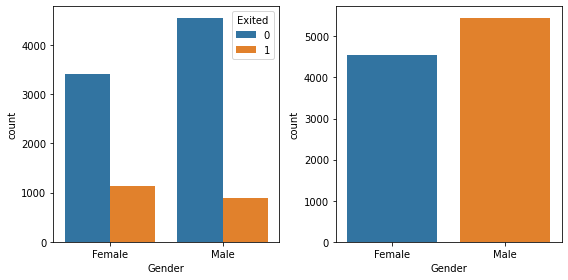

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(ax=axes[0], data=df, x='Gender', hue='Exited')
sns.countplot(ax=axes[1], data=df, x='Gender')
plt.tight_layout();

Female customers are more likely to churn

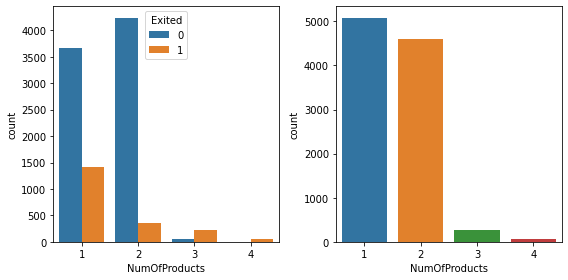

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(ax=axes[0], data=df, x='NumOfProducts', hue='Exited')
sns.countplot(ax=axes[1], data=df, x='NumOfProducts')
plt.tight_layout();

Looks like if the customers have more products their likelihood to churn increases

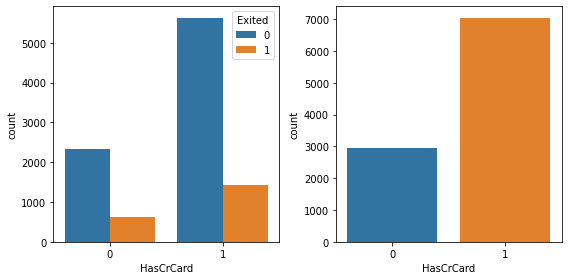

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.countplot(ax=axes[0], data=df, x='HasCrCard', hue='Exited')
sns.countplot(ax=axes[1], data=df, x='HasCrCard')
plt.tight_layout();

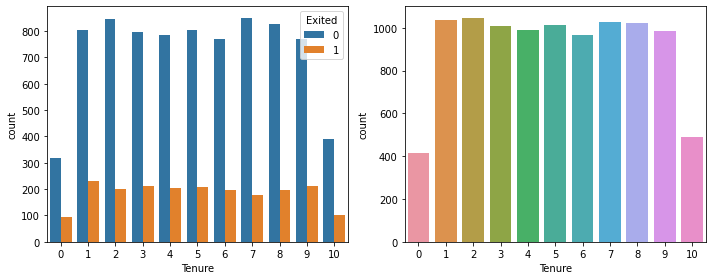

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(ax=axes[0], data=df, x='Tenure', hue='Exited')
sns.countplot(ax=axes[1], data=df, x='Tenure')
plt.tight_layout();

Customers at the extreme ends are more likely to churn than the ones in the middle part

In [79]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [80]:
# Converting the data type to categorical
for i in categorical:
    df[i] = df[i].astype(str)

In [81]:
X = df.drop('Exited', axis=1)
y = df.Exited

In [82]:
# Getting the dummy variables
X = pd.get_dummies(X)

In [83]:
# Addressing the class imbalance by over sampling
new_df = SMOTE()
X, y = new_df.fit_resample(X, y)

In [84]:
y.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

## Modeling

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Random forest

In [86]:
rf = RandomForestClassifier()
param_grid = {
    'n_estimators':[65,100,120],
    'max_features':['auto', 'sqrt'],
    'min_samples_leaf': [5,10],
    'min_samples_split': [5,10]
}

grid_rf = GridSearchCV(rf, param_grid)

In [87]:
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [65, 100, 120]})

In [88]:
grid_rf.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 65}

In [89]:
preds = grid_rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1633
           1       0.94      0.88      0.91      1553

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



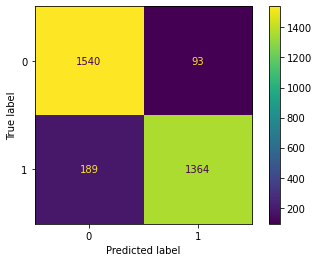

In [90]:
plot_confusion_matrix(grid_rf, X_test, y_test)

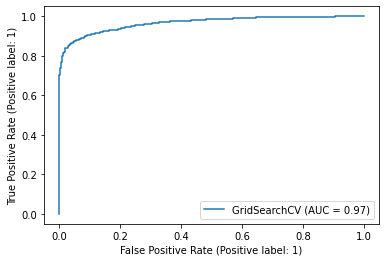

In [91]:
plot_roc_curve(grid_rf, X_test, y_test)

In [92]:
features = grid_rf.best_estimator_.feature_importances_
imp_features = pd.DataFrame(index=X.columns, data=features, columns=['importance'])
imp_features = imp_features[imp_features.importance>0.001]
imp_features = imp_features.reset_index()
imp_features.columns = ['feature', 'importance']
imp_features = imp_features.sort_values(by='importance', ascending=False)

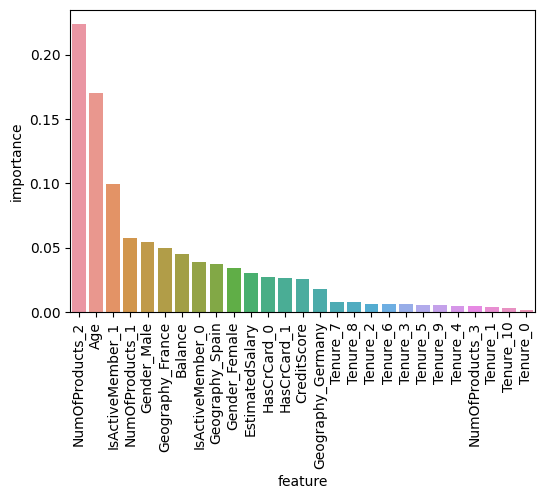

In [93]:
plt.figure(figsize=(6,4), dpi=100)
sns.barplot(data=imp_features, x=imp_features.feature, y=imp_features.importance)
plt.xticks(rotation=90);

#### Gradient boosting

In [94]:
gbc = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [65, 100],
    'subsample': [0.5, 0.75],
    'max_depth': [3, 4],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10],
    'max_features': ['auto', 'log2']
}

In [95]:
gbc_clf = GridSearchCV(estimator=gbc, param_grid=param_grid, verbose=False)

In [96]:
gbc_clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 4], 'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [65, 100], 'subsample': [0.5, 0.75]},
             verbose=False)

In [97]:
gbc_clf.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100,
 'subsample': 0.5}

In [98]:
preds = gbc_clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1633
           1       0.94      0.88      0.91      1553

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



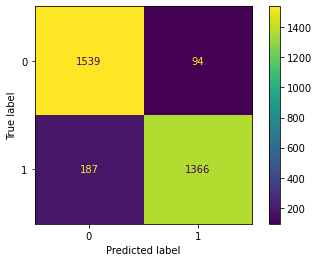

In [99]:
plot_confusion_matrix(gbc_clf, X_test, y_test)

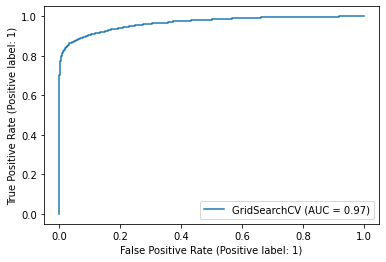

In [100]:
plot_roc_curve(gbc_clf, X_test, y_test)

In [101]:
features = gbc_clf.best_estimator_.feature_importances_
imp_features = pd.DataFrame(index=X.columns, data=features, columns=['importance'])
imp_features = imp_features[imp_features.importance>0.001]
imp_features = imp_features.reset_index()
imp_features.columns = ['feature', 'importance']
imp_features = imp_features.sort_values(by='importance', ascending=False)

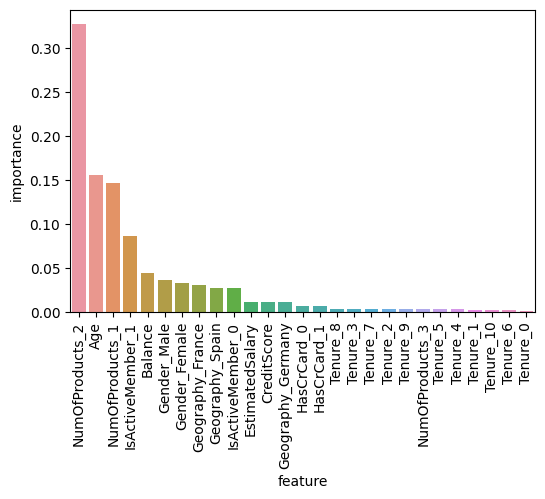

In [102]:
plt.figure(figsize=(6,4), dpi=100)
sns.barplot(data=imp_features, x=imp_features.feature, y=imp_features.importance)
plt.xticks(rotation=90);

#### Xgboost

In [103]:
xgb = XGBClassifier()

param_grid = {
    'n_estimators': [50, 65],
    'max_depth': [3, 4, 6],  
    'subsample': [0.5, 0.75], #fraction of sample to be used
    'colsample_bytree': [0.50, 0.75], #subsample ratio of columns when constructing each tree
    'gamma': [0.1, 0.15, 0.2], #minimum split loss, larger gamma more conservative the model will be
    'min_child_weight': [0.5, 1] #minimum sum of weights of all observations required in a child
}

In [104]:
grid_xgb = GridSearchCV(xgb, param_grid)

In [105]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'gamma': [0.1, 0.15, 0.2], 'max_depth': [3, 4, 6],
                         'min_child_weight': [0.5, 1], 'n_estimators': [50, 65],
                         'subsample': [0.5, 0.75]})

In [106]:
grid_xgb.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.15,
 'max_depth': 6,
 'min_child_weight': 0.5,
 'n_estimators': 65,
 'subsample': 0.75}

In [107]:
preds = grid_xgb.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1633
           1       0.93      0.89      0.91      1553

    accuracy                           0.91      3186
   macro avg       0.92      0.91      0.91      3186
weighted avg       0.92      0.91      0.91      3186



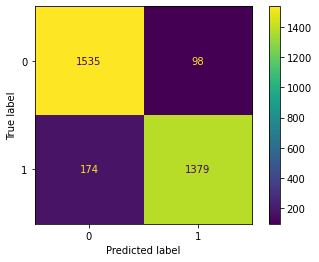

In [108]:
plot_confusion_matrix(grid_xgb, X_test, y_test)

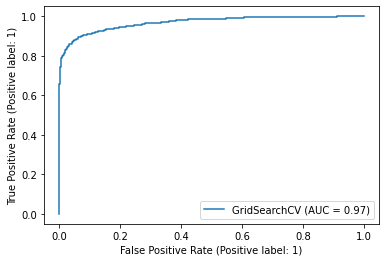

In [109]:
plot_roc_curve(grid_xgb, X_test, y_test)

In [110]:
features = grid_xgb.best_estimator_.feature_importances_
imp_features = pd.DataFrame(index=X.columns, data=features, columns=['importance'])
imp_features = imp_features[imp_features.importance>0.001]
imp_features = imp_features.reset_index()
imp_features.columns = ['feature', 'importance']
imp_features = imp_features.sort_values(by='importance', ascending=False)

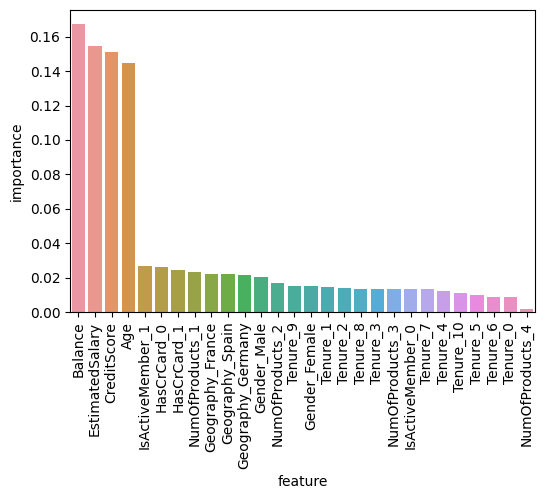

In [111]:
plt.figure(figsize=(6,4), dpi=100)
sns.barplot(data=imp_features, x=imp_features.feature, y=imp_features.importance)
plt.xticks(rotation=90);